In [1]:
# Cellule 1 : Imports
import numpy as np
import random
import math
import copy
import time
from IPython.display import clear_output, HTML, display, update_display
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
import os
import csv
from numba import njit
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import threading
import queue
import multiprocessing as mp
from multiprocessing import Manager, Queue
import traceback

# Fixer la graine pour la reproductibilité
random.seed(56)
np.random.seed(56)

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'sans-serif'

In [2]:
# Cellule 2 : Fonctions utilitaires et Fonction de Coût
def generate_sudoku(n, holes):
    s = math.isqrt(n)
    def pattern(r, c): return (s * (r % s) + r // s + c) % n
    def shuffle(amt): return random.sample(amt, len(amt))
    r_base = range(s)
    rows = [g * s + r for g in shuffle(r_base) for r in shuffle(r_base)]
    cols = [g * s + c for g in shuffle(r_base) for c in shuffle(r_base)]
    nums = shuffle(range(1, n + 1))
    board = [[nums[pattern(r, c)] for c in cols] for r in rows]
    
    indices_to_remove = random.sample(range(n * n), min(n*n, holes))
    for idx in indices_to_remove:
        board[idx // n][idx % n] = 0
        
    return [val for row in board for val in row]

def get_initial_board(input_string):
    if isinstance(input_string, str):
        data = [int(c) for c in input_string]
    else:
        data = input_string
    n = int(len(data)**0.5)
    return np.array(data, dtype=np.int16).reshape((n, n))

def initialize_grid(fixed_board):
    n = len(fixed_board)
    s = math.isqrt(n)
    current_board = np.copy(fixed_board)
    fixed_mask = (fixed_board != 0) 
    
    for i in range(0, n, s):
        for j in range(0, n, s):
            block = current_board[i:i+s, j:j+s]
            existing = set(block[block != 0])
            missing = [n_val for n_val in range(1, n + 1) if n_val not in existing]
            random.shuffle(missing)
            
            idx = 0
            for r in range(i, i+s):
                for c in range(j, j+s):
                    if current_board[r, c] == 0:
                        current_board[r, c] = missing[idx]
                        idx += 1
                        
    return current_board, fixed_mask

def generate_table(n_elements, start=0, end=100, mode="none"):
    precision = (end - start) / n_elements
    x = np.arange(start, end + precision, precision)
    x_bruite = np.clip(x + np.random.normal(0, precision, len(x)), start, end)
    for i in range(1, len(x_bruite)):
        if np.isclose(x_bruite[i], x_bruite[i-1], atol=precision):
            x_bruite[i] += np.random.normal(0, precision/2)
    
    if mode == "ascending":
        x_bruite = np.sort(x_bruite)
    elif mode == "descending":
        x_bruite = np.sort(x_bruite)[::-1]
    elif mode == "random":
        np.random.shuffle(x_bruite)
    
    return x_bruite

def get_dynamic_window(n_count):
    slope = (150 - 5) / (60000 - 400)
    window = 50 + (n_count - 400) * slope
    if n_count > 100:
        return int(max(100, window))
    else:
        return 5

@njit(fastmath=True, nogil=True)
def calculate_energy(board):
    n = len(board)
    score = 0
    for i in range(n):
        unique_row = set()
        for x in board[i, :]:
            unique_row.add(x)
        score += (n - len(unique_row))
        
    for j in range(n):
        unique_col = set()
        for x in board[:, j]:
            unique_col.add(x)
        score += (n - len(unique_col))
    return score

def format_duration(seconds):
    days = int(seconds // 86400)
    seconds %= 86400
    hours = int(seconds // 3600)
    seconds %= 3600
    minutes = int(seconds // 60)
    seconds %= 60
    
    parts = []
    if days > 0:
        parts.append(f"{days}j")
    if hours > 0:
        parts.append(f"{hours}h")
    if minutes > 0:
        parts.append(f"{minutes}min")
    
    if days == 0 and hours == 0 and minutes == 0:
        if seconds == 0:
            parts.append("0s")
        elif seconds < 10:
            parts.append(f"{seconds:.2f}s".rstrip('0').rstrip('.'))
        else:
            parts.append(f"{int(seconds)}s")
    else:
        parts.append(f"{int(seconds)}s")
        
    return "".join(parts)

def display_sudoku(grid):
    n = len(grid)
    s = math.isqrt(n)
    conflicts = np.zeros((n, n), dtype=bool)
    for i in range(n):
        row = grid[i, :]
        vals, counts = np.unique(row, return_counts=True)
        dupes = vals[(vals != 0) & (counts > 1)]
        conflicts[i, np.isin(row, dupes)] = True
        
        col = grid[:, i]
        vals, counts = np.unique(col, return_counts=True)
        dupes = vals[(vals != 0) & (counts > 1)]
        conflicts[np.isin(col, dupes), i] = True

    for r0 in range(0, n, s):
        for c0 in range(0, n, s):
            block = grid[r0:r0+s, c0:c0+s]
            vals, counts = np.unique(block, return_counts=True)
            dupes = vals[(vals != 0) & (counts > 1)]
            if len(dupes) > 0:
                conflicts[r0:r0+s, c0:c0+s] |= np.isin(block, dupes)
    
    cell_size = max(20, min(40, 800 // n))
    table_w = n * cell_size + (n // s) * 2
    
    html = [f'<div style="display:flex; flex-direction:column; align-items:center; margin:20px auto;">']
    html.append(f'<table style="table-layout:fixed; width:{table_w}px; border:3px solid #000; border-collapse:collapse; background-color:#fff;">')
    
    for r in range(n):
        b_bottom = "3px solid #000" if (r + 1) % s == 0 and r != n - 1 else "1px solid #ddd"
        html.append(f'<tr style="height:{cell_size}px; border-bottom:{b_bottom};">')
        for c in range(n):
            b_right = "3px solid #000" if (c + 1) % s == 0 and c != n - 1 else "1px solid #ddd"
            if conflicts[r, c]:
                bg_color, color = "#fee2e2", "#dc2626"
            else:
                bg_color = "#ffffff" if ((r // s) + (c // s)) % 2 == 0 else "#f9fafb"
                color = "#1f2937"
            
            val = int(grid[r][c])
            val_str = str(val) if val != 0 else ""
            html.append(f'<td style="width:{cell_size}px; height:{cell_size}px; padding:0; text-align:center; vertical-align:middle; '
                        f'border-right:{b_right}; background-color:{bg_color}; color:{color}; font-family:monospace; '
                        f'font-weight:bold; font-size:{cell_size//2}px; line-height:{cell_size}px;">{val_str}</td>')
        html.append('</tr>')
    
    html.append('</table>')
    energy = calculate_energy(grid)
    status = f"Énergie : {energy} {'(Résolu)' if energy == 0 else '(En cours)'}"
    html.append(f'<div style="margin-top:10px; font-family:sans-serif; font-size:14px; font-weight:bold; color:{"#059669" if energy==0 else "#4b5563"}">{status}</div></div>')
    display(HTML("".join(html)))

In [3]:
# Cellule 3 : Le Solveur Monte Carlo
@njit(fastmath=True, nogil=True)
def run_batch(board, block_coords, block_counts, 
              current_energy, best_energy, best_board,
              row_counts, col_counts,
              temp, cooling_rate, initial_temp, 
              steps_batch, total_steps_done, 
              n_accepted, n_rejected, n_improved, n_restarts):
    
    n = len(board)
    num_blocks = len(block_counts)
    local_step = 0
    
    if current_energy == 0:
        return current_energy, best_energy, temp, total_steps_done, n_accepted, n_rejected, n_improved, n_restarts

    while local_step < steps_batch:
        if current_energy == 0:
            break

        rand_blk_idx = np.random.randint(0, num_blocks)
        cnt = block_counts[rand_blk_idx]
        
        if cnt < 2:
            local_step += 1
            continue
            
        idx1 = np.random.randint(0, cnt)
        idx2_offset = np.random.randint(1, cnt)
        idx2 = (idx1 + idx2_offset) % cnt
            
        r1, c1 = block_coords[rand_blk_idx, idx1]
        r2, c2 = block_coords[rand_blk_idx, idx2]
        
        v1 = board[r1, c1]
        v2 = board[r2, c2]
        
        if v1 == v2:
            n_rejected += 1
            local_step += 1
            continue
            
        d_e = 0
        if r1 != r2:
            if row_counts[r1, v1] == 1: d_e += 1
            if row_counts[r1, v2] == 0: d_e -= 1
            if row_counts[r2, v2] == 1: d_e += 1
            if row_counts[r2, v1] == 0: d_e -= 1
            
        if c1 != c2:
            if col_counts[c1, v1] == 1: d_e += 1
            if col_counts[c1, v2] == 0: d_e -= 1
            if col_counts[c2, v2] == 1: d_e += 1
            if col_counts[c2, v1] == 0: d_e -= 1

        if d_e <= 0 or (temp > 1e-9 and np.random.random() < math.exp(-d_e / temp)):
            if d_e < 0: n_improved += 1
            n_accepted += 1
            
            board[r1, c1] = v2
            board[r2, c2] = v1
            
            row_counts[r1, v1] -= 1; row_counts[r1, v2] += 1
            row_counts[r2, v2] -= 1; row_counts[r2, v1] += 1
            col_counts[c1, v1] -= 1; col_counts[c1, v2] += 1
            col_counts[c2, v2] -= 1; col_counts[c2][v1] += 1
            
            current_energy += d_e
            
            if current_energy < best_energy:
                best_energy = current_energy
                for rr in range(n):
                    for cc in range(n):
                        best_board[rr, cc] = board[rr, cc]
        else:
            n_rejected += 1
            
        temp *= cooling_rate
        
        if temp < 0.005 and current_energy > 0:
            n_restarts += 1
            temp = initial_temp
            current_energy = best_energy
            for rr in range(n):
                for cc in range(n):
                    board[rr, cc] = best_board[rr, cc]
            
            row_counts[:] = 0
            col_counts[:] = 0
            for rr in range(n):
                for cc in range(n):
                    val = board[rr, cc]
                    row_counts[rr, val] += 1
                    col_counts[cc, val] += 1
        
        local_step += 1
        total_steps_done += 1
        
    return current_energy, best_energy, temp, total_steps_done, n_accepted, n_rejected, n_improved, n_restarts

@njit(fastmath=True, nogil=True)
def run_greedy(board, block_coords, block_counts, 
               current_energy, row_counts, col_counts, steps_limit):
    
    num_blocks = len(block_counts)
    local_step = 0
    
    if current_energy == 0:
        return current_energy

    while local_step < steps_limit:
        if current_energy == 0:
            break

        rand_blk_idx = np.random.randint(0, num_blocks)
        cnt = block_counts[rand_blk_idx]
        
        if cnt < 2:
            local_step += 1
            continue
            
        idx1 = np.random.randint(0, cnt)
        idx2_offset = np.random.randint(1, cnt)
        idx2 = (idx1 + idx2_offset) % cnt
            
        r1, c1 = block_coords[rand_blk_idx, idx1]
        r2, c2 = block_coords[rand_blk_idx, idx2]
        
        v1 = board[r1, c1]
        v2 = board[r2, c2]
        
        if v1 == v2:
            local_step += 1
            continue
            
        d_e = 0
        if r1 != r2:
            if row_counts[r1, v1] == 1: d_e += 1
            if row_counts[r1, v2] == 0: d_e -= 1
            if row_counts[r2, v2] == 1: d_e += 1
            if row_counts[r2, v1] == 0: d_e -= 1
            
        if c1 != c2:
            if col_counts[c1, v1] == 1: d_e += 1
            if col_counts[c1, v2] == 0: d_e -= 1
            if col_counts[c2, v2] == 1: d_e += 1
            if col_counts[c2, v1] == 0: d_e -= 1

        if d_e < 0:
            board[r1, c1] = v2
            board[r2, c2] = v1
            
            row_counts[r1, v1] -= 1; row_counts[r1, v2] += 1
            row_counts[r2, v2] -= 1; row_counts[r2, v1] += 1
            col_counts[c1, v1] -= 1; col_counts[c1, v2] += 1
            col_counts[c2, v2] -= 1; col_counts[c2][v1] += 1
            
            current_energy += d_e
        
        local_step += 1
        
    return current_energy

def solve_sudoku_parallel_tempering(initial_grid_str, max_steps=None, initial_temp=None, cooling_rate=None, infinite_mode=False, 
                                    status_queue=None, slot_id=None, filled_pct=None):
    # Suppression de ThreadPoolExecutor pour éviter la surcharge de threading et le blocage
    
    t_start = time.time()
    fixed_board = get_initial_board(initial_grid_str)
    n = len(fixed_board)
    s = int(math.isqrt(n))
    
    n_replicas = 4
    
    if initial_temp is None: initial_temp = 2.0
    temps = [initial_temp * (0.1 ** (i / (n_replicas - 1))) for i in range(n_replicas)]
    
    if infinite_mode:
        steps_limit = 1000000000
    else:
        # Adaptation dynamique : pour n=100, n**4 est gigantesque (100M).
        # On limite pour avoir un temps raisonnable tout en restant suffisant pour converger si possible.
        if max_steps is None: max_steps = int((n**4) * s * 1.5)
        steps_limit = int(max_steps)

    replicas = []
    
    max_cells_per_block = s * s
    num_blocks = (n // s) ** 2
    block_coords_np = np.zeros((num_blocks, max_cells_per_block, 2), dtype=np.int16)
    block_counts_np = np.zeros(num_blocks, dtype=np.int16)
    
    temp_grid, fixed_mask = initialize_grid(fixed_board)
    initial_holes = np.sum(~fixed_mask)
    
    blk_idx = 0
    for r0 in range(0, n, s):
        for c0 in range(0, n, s):
            count = 0
            for r in range(r0, r0+s):
                for c in range(c0, c0+s):
                    if not fixed_mask[r, c]:
                        block_coords_np[blk_idx, count, 0] = r
                        block_coords_np[blk_idx, count, 1] = c
                        count += 1
            block_counts_np[blk_idx] = count
            blk_idx += 1
    
    active_blocks = np.sum(block_counts_np >= 2)
    initial_energy_val = calculate_energy(temp_grid)
    
    for i in range(n_replicas):
        current_board = temp_grid.copy()
        
        row_counts = np.zeros((n, n + 1), dtype=np.int16)
        col_counts = np.zeros((n, n + 1), dtype=np.int16)
        for r in range(n):
            for c in range(n):
                val = current_board[r, c]
                row_counts[r, val] += 1
                col_counts[c, val] += 1
                
        replicas.append({
            'board': current_board,
            'energy': initial_energy_val,
            'best_energy': initial_energy_val,
            'best_board': current_board.copy(),
            'row_counts': row_counts,
            'col_counts': col_counts,
            'temp': temps[i],
            'n_acc': 0, 'n_rej': 0, 'n_imp': 0, 'n_res': 0
        })

    global_best_energy = initial_energy_val
    global_best_board = temp_grid.copy()
    
    total_steps = 0
    
    # Ajustement Dynamique du Batch Size pour les grands N
    # Pour N=9, N^2=81, Batch~2000. Pour N=100, N^2=10000, Batch~200000.
    # Cela évite de spammer la Queue et le contexte Python.
    BATCH_SIZE = max(2000, int(20 * n**2)) 
    
    SWAP_INTERVAL = 5
    GREEDY_STEPS = max(500, int(n * 10))
    
    history_s = []
    history_e = []
    history_t = []
    history_b = []
    
    last_update_time = time.time()
    steps_accumulator = 0
    UPDATE_INTERVAL = 0.05
    
    steps_to_best = 0
    time_to_best = 0.0
    
    if status_queue is not None and slot_id is not None:
        desc_text = f"PT {n}x{n}"
        if filled_pct is not None:
            desc_text += f" ({filled_pct:.0f}%)"
        status_queue.put(('init', slot_id, steps_limit, initial_energy_val, desc_text))

    # Exécution Séquentielle des répliques (Plus efficace que ThreadPool imbriqué)
    while total_steps < steps_limit and global_best_energy > 0:
        
        for i in range(n_replicas):
            rep = replicas[i]
            if rep['energy'] == 0: continue
            
            curr, best, t_out, _, acc, rej, imp, res = run_batch(
                rep['board'], block_coords_np, block_counts_np,
                rep['energy'], rep['best_energy'], rep['best_board'],
                rep['row_counts'], rep['col_counts'],
                rep['temp'], 1.0, rep['temp'],
                BATCH_SIZE, 0,
                0, 0, 0, 0
            )
            
            rep['energy'] = curr
            rep['best_energy'] = best
            rep['n_acc'] += acc
            rep['n_rej'] += rej
            rep['n_imp'] += imp
            rep['n_res'] += res
        
        lowest_temp_idx = n_replicas - 1
        rep_cold = replicas[lowest_temp_idx]
        if rep_cold['energy'] > 0:
            new_e = run_greedy(
                rep_cold['board'], block_coords_np, block_counts_np,
                rep_cold['energy'], rep_cold['row_counts'], rep_cold['col_counts'],
                GREEDY_STEPS
            )
            rep_cold['energy'] = new_e
            if new_e < rep_cold['best_energy']:
                 rep_cold['best_energy'] = new_e
                 rep_cold['best_board'] = rep_cold['board'].copy()

        for rep in replicas:
            if rep['best_energy'] < global_best_energy:
                global_best_energy = rep['best_energy']
                global_best_board = rep['best_board'].copy()
                steps_to_best = total_steps
                time_to_best = time.time() - t_start

        if total_steps % (BATCH_SIZE * SWAP_INTERVAL) == 0:
            for i in range(n_replicas - 1):
                r1 = replicas[i]
                r2 = replicas[i+1]
                
                beta1 = 1.0 / r1['temp']
                beta2 = 1.0 / r2['temp']
                dE = r1['energy'] - r2['energy']
                d_beta = beta1 - beta2
                
                delta = d_beta * dE
                
                if delta > 0 or np.random.random() < math.exp(delta):
                    r1['board'], r2['board'] = r2['board'], r1['board']
                    r1['energy'], r2['energy'] = r2['energy'], r1['energy']
                    r1['row_counts'], r2['row_counts'] = r2['row_counts'], r1['row_counts']
                    r1['col_counts'], r2['col_counts'] = r2['col_counts'], r1['col_counts']
                    
                    if r1['best_energy'] < r1['energy']:
                         r1['best_board'] = r1['board'].copy()
                         r1['best_energy'] = r1['energy']
                    if r2['best_energy'] < r2['energy']:
                         r2['best_board'] = r2['board'].copy()
                         r2['best_energy'] = r2['energy']

        total_steps += BATCH_SIZE
        steps_accumulator += BATCH_SIZE
        
        history_s.append(total_steps)
        history_e.append(replicas[-1]['energy']) 
        history_t.append(replicas[-1]['temp'])
        history_b.append(global_best_energy)
        
        current_time = time.time()
        if (current_time - last_update_time > UPDATE_INTERVAL) or (global_best_energy == 0):
            if status_queue is not None:
                total_res = sum(r['n_res'] for r in replicas)
                status_queue.put(('update', slot_id, steps_accumulator, replicas[-1]['energy'], global_best_energy, replicas[-1]['temp'], total_res))
            steps_accumulator = 0
            last_update_time = current_time

    duration = time.time() - t_start
    
    if steps_to_best == 0 and global_best_energy < initial_energy_val:
        time_to_best = duration
        steps_to_best = total_steps

    total_acc = sum(r['n_acc'] for r in replicas)
    total_rej = sum(r['n_rej'] for r in replicas)
    total_imp = sum(r['n_imp'] for r in replicas)
    total_res = sum(r['n_res'] for r in replicas)

    if steps_accumulator > 0 and status_queue is not None:
        status_queue.put(('update', slot_id, steps_accumulator, replicas[-1]['energy'], global_best_energy, replicas[-1]['temp'], total_res))

    return global_best_board, (history_s, history_e, history_t, history_b, duration, initial_energy_val, total_acc, total_rej, total_imp, total_res, 0.0, initial_temp, 0.0, total_steps, np.sum(fixed_mask), initial_holes, active_blocks, steps_to_best, time_to_best)

In [4]:
# Cellule 4 : Fonctions de test (Moteur, Classique et Adaptatif)
def worker_thread_func(task_queue, slot_queue, status_queue):
    while True:
        try:
            task_args = task_queue.get(timeout=0.1)
        except queue.Empty:
            break 
            
        n_size, holes, run_id, pct, weight, infinite_mode = task_args
        slot_id = slot_queue.get()
        
        try:
            sudoku = generate_sudoku(n_size, holes)
            
            solution, stats = solve_sudoku_parallel_tempering(
                sudoku,
                infinite_mode=infinite_mode,
                status_queue=status_queue,
                slot_id=slot_id,
                filled_pct=pct
            )
            
            s, e, t, b, duration, e_init, n_acc, n_rej, n_imp, n_res, t_end, t_init, c_rate, steps, n_fixed, init_holes, act_blks, stp_best, tm_best = stats
            final_energy = calculate_energy(solution)
            success = (final_energy == 0)
            
            acc_rate = n_acc / steps if steps > 0 else 0
            imp_rate = n_imp / steps if steps > 0 else 0
            ips = steps / duration if duration > 0 else 0
            
            result_row = [n_size, run_id, pct, success, duration, steps, e_init, final_energy, t_init, t_end, c_rate, n_res, n_acc, n_rej, n_imp, n_fixed, init_holes, act_blks, stp_best, tm_best, acc_rate, imp_rate, ips]
            
            status_queue.put(('result', slot_id, result_row, weight))
            
        except Exception as e:
            print(f"Erreur Worker {slot_id}: {e}")
            traceback.print_exc()
            status_queue.put(('error', slot_id, weight))
        finally:
            slot_queue.put(slot_id)
            task_queue.task_done()

def execute_test_campaign(tasks_with_weights, csv_file):
    if not tasks_with_weights:
        print("Aucune tâche à exécuter.")
        return

    if not os.path.isfile(csv_file):
        with open(csv_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["N_Size", "Run_ID", "Fixed_Pct", "Success", "Duration", "Iterations", "Energy_Init", "Energy_Final", "Temp_Init", "Temp_Final", "Cooling_Rate", "Restarts", "Accepted", "Rejected", "Improved", "Fixed_Count", "Holes_Count", "Active_Blocks", "Steps_To_Best", "Time_To_Best", "Accept_Rate", "Improve_Rate", "Iter_Per_Sec"])

    num_workers = min(os.cpu_count(), 10)
    total_work_weight = sum(t[4] for t in tasks_with_weights)
    if total_work_weight == 0: total_work_weight = 1
    total_estimated_wall_seconds = total_work_weight / num_workers
    total_duration_str = format_duration(total_estimated_wall_seconds)
    
    status_queue = queue.Queue()
    slot_queue = queue.Queue()
    task_queue = queue.Queue()
    
    for i in range(num_workers):
        slot_queue.put(i)
        
    for task in tqdm(tasks_with_weights, desc="Distribution des tâches", colour='orange', leave=False):
        task_queue.put(task)
        
    threads = []
    for _ in range(num_workers):
        t = threading.Thread(target=worker_thread_func, args=(task_queue, slot_queue, status_queue))
        t.start()
        threads.append(t)
    
    pbar_global = tqdm(total=int(total_work_weight), desc=f"Progression Globale (0s / {total_duration_str})", 
                       position=0, bar_format='{l_bar}{bar}| [ETA: {remaining}]', colour='green', mininterval=1.0)
    
    worker_pbars = []
    for i in range(num_workers):
        pb_iter = tqdm(total=100, desc=f"W{i} Attente...", position=1 + 2*i, leave=True, colour='blue', mininterval=0.2, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
        pb_ener = tqdm(total=100, desc=f"W{i} ...", position=2 + 2*i, leave=True, colour='red', mininterval=0.2, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [Err: {n_fmt}]')
        worker_pbars.append({'iter': pb_iter, 'energy': pb_ener})
        
    completed_tasks = 0
    total_tasks = len(tasks_with_weights)
    global_start_time = time.time()
    
    while completed_tasks < total_tasks:
        try:
            msg = status_queue.get(timeout=0.1)
            m_type, slot = msg[0], msg[1]
            
            if m_type == 'init':
                limit, init_e, desc = msg[2], msg[3], msg[4]
                worker_pbars[slot]['iter'].reset(total=limit)
                worker_pbars[slot]['iter'].set_description(f"W{slot} {desc}")
                worker_pbars[slot]['energy'].reset(total=init_e)
                worker_pbars[slot]['energy'].n = 0
                worker_pbars[slot]['energy'].set_description(f"W{slot} Convergence")
                worker_pbars[slot]['energy'].refresh()
                
            elif m_type == 'update':
                steps, curr_e, best_e, temp, restarts = msg[2], msg[3], msg[4], msg[5], msg[6]
                worker_pbars[slot]['iter'].update(steps)
                worker_pbars[slot]['iter'].set_postfix({"T": f"{temp:.4f}", "R": restarts})
                prog = worker_pbars[slot]['energy'].total - curr_e
                worker_pbars[slot]['energy'].n = max(0, prog)
                worker_pbars[slot]['energy'].set_postfix({"E": curr_e, "Best": best_e})
                worker_pbars[slot]['energy'].refresh()
                
            elif m_type == 'result':
                res_row, w_weight = msg[2], msg[3]
                with open(csv_file, mode='a', newline='') as f:
                    csv.writer(f).writerow(res_row)
                pbar_global.update(w_weight)
                curr_t_str = format_duration(pbar_global.n / num_workers)
                pbar_global.set_description(f"Progression ({curr_t_str} / {total_duration_str})")
                completed_tasks += 1
                worker_pbars[slot]['iter'].set_description(f"W{slot} Inactif")
                worker_pbars[slot]['energy'].set_description(f"W{slot} ...")
            
            elif m_type == 'error':
                w_weight = msg[2]
                pbar_global.update(w_weight)
                completed_tasks += 1
                worker_pbars[slot]['iter'].set_description(f"W{slot} Erreur")
                worker_pbars[slot]['energy'].set_description(f"W{slot} ...")
        
        except queue.Empty:
            if not any(t.is_alive() for t in threads):
                break
            continue
        except Exception as e:
            print(f"Erreur Loop: {e}")
            
    for t in threads:
        t.join()
    
    pbar_global.close()
    for wb in worker_pbars:
        wb['iter'].close()
        wb['energy'].close()
        
    total_real_duration = time.time() - global_start_time
    display(HTML(f"<h3 style='color:green'>Campagne terminée. Statistiques dans {csv_file}. Durée réelle : {format_duration(total_real_duration)}</h3>"))

def test_classic(csv_file, n_min_sqrt=2, n_max_sqrt=9, repetitions_par_n=1, remplissage_percentages=[40, 50, 60], infinite_mode=None):
    display(HTML("<h3>Lancement de la campagne Classique...</h3>"))
    tasks_metadata = []
    for n_sqrt in range(n_min_sqrt, n_max_sqrt + 1):
        n_size = n_sqrt**2
        for pct in remplissage_percentages:
            for i in range(repetitions_par_n):
                tasks_metadata.append((n_size, pct, i+1))
                
    history_weights = {}
    if os.path.isfile(csv_file):
        try:
            df_hist = pd.read_csv(csv_file)
            stats = df_hist.groupby(['N_Size', 'Fixed_Pct'])['Duration'].mean()
            history_weights = stats.to_dict()
        except Exception:
            pass

    tasks_with_weights = []
    for (n, pct, rid) in tqdm(tasks_metadata, desc="Calcul des poids", colour='orange', leave=False):
        weight = 1.0
        approx_key = (n, pct)
        
        if history_weights:
            closest_k = min(history_weights.keys(), key=lambda k: abs(k[0]-n) + abs(k[1]-pct) if k[0]==n else 9999)
            if closest_k[0] == n and abs(closest_k[1] - pct) < 5:
                weight = history_weights[closest_k]
            else:
                scale_n = (n / 9.0) ** 4.5
                dist_peak = abs(pct - 40)
                weight = (0.2 * scale_n * (1.0 if dist_peak < 15 else (0.2 if dist_peak < 30 else 0.05)))
        else:
             scale_n = (n / 9.0) ** 4.5
             dist_peak = abs(pct - 40)
             weight = (0.2 * scale_n * (1.0 if dist_peak < 15 else (0.2 if dist_peak < 30 else 0.05)))
             
        weight = max(0.01, weight)
        use_infinite = infinite_mode if infinite_mode is not None else (n > 81)
        holes = int(n**2 * (1 - (pct / 100)))
        tasks_with_weights.append((n, holes, rid, pct, weight, use_infinite))
        
    execute_test_campaign(tasks_with_weights, csv_file)

def test_adaptive(csv_file, n_min_sqrt=2, n_max_sqrt=9, repetitions_par_n=1, new_points_per_n=20, infinite_mode=None):
    display(HTML("<h3>Analyse des données et Lancement de la campagne Adaptative...</h3>"))
    
    existing_df = pd.DataFrame()
    if os.path.isfile(csv_file):
        try:
            existing_df = pd.read_csv(csv_file)
        except:
            pass
            
    tasks_metadata = []
    
    for n_sqrt in range(n_min_sqrt, n_max_sqrt + 1):
        n_size = n_sqrt**2
        points_to_test = []
        
        has_data = False
        if not existing_df.empty:
            df_n = existing_df[existing_df['N_Size'] == n_size]
            if len(df_n) > 3:
                has_data = True
                agg = df_n.groupby('Fixed_Pct')['Duration'].mean().sort_index()
                x_vals = agg.index.to_numpy()
                y_vals = agg.to_numpy()
                
                dx = np.diff(x_vals)
                dy = np.abs(np.diff(y_vals))
                
                norm_dx = dx / (dx.max() + 1e-9)
                norm_dy = dy / (dy.max() + 1e-9)
                
                scores = norm_dx + 1.5 * norm_dy
                top_indices = np.argsort(scores)[::-1]
                
                count_added = 0
                for idx in top_indices:
                    mid_point = (x_vals[idx] + x_vals[idx+1]) / 2
                    points_to_test.append(mid_point)
                    count_added += 1
                    if count_added >= new_points_per_n:
                        break
                        
                if x_vals.min() > 10: points_to_test.append(x_vals.min() / 2)
                if x_vals.max() < 90: points_to_test.append((x_vals.max() + 100) / 2)
        
        if not has_data:
            points_to_test = np.linspace(20, 80, new_points_per_n).tolist()
            
        for pct in points_to_test:
            for i in range(repetitions_par_n):
                tasks_metadata.append((n_size, pct, i+1))
                
    history_weights = {}
    if not existing_df.empty:
        try:
            stats = existing_df.groupby(['N_Size', 'Fixed_Pct'])['Duration'].mean()
            history_weights = stats.to_dict()
        except:
            pass
            
    tasks_with_weights = []
    for (n, pct, rid) in tqdm(tasks_metadata, desc="Calcul des poids et préparation", colour='orange', leave=False):
        weight = 1.0
        if history_weights:
            closest_k = min(history_weights.keys(), key=lambda k: abs(k[0]-n) + abs(k[1]-pct) if k[0]==n else 9999)
            if closest_k[0] == n and abs(closest_k[1] - pct) < 5:
                weight = history_weights[closest_k]
            else:
                scale_n = (n / 9.0) ** 4.5
                dist_peak = abs(pct - 40)
                weight = (0.2 * scale_n * (1.0 if dist_peak < 15 else (0.2 if dist_peak < 30 else 0.05)))
        else:
             scale_n = (n / 9.0) ** 4.5
             dist_peak = abs(pct - 40)
             weight = (0.2 * scale_n * (1.0 if dist_peak < 15 else (0.2 if dist_peak < 30 else 0.05)))
             
        weight = max(0.01, weight)
        use_infinite = infinite_mode if infinite_mode is not None else (n > 81)
        holes = int(n**2 * (1 - (pct / 100)))
        tasks_with_weights.append((n, holes, rid, pct, weight, use_infinite))
        
    execute_test_campaign(tasks_with_weights, csv_file)

In [15]:
print(df['N_Size'].value_counts().sort_index())

N_Size
1       1042
4      88769
9      67307
16     40775
25     36482
36      2814
49      1285
64      1299
81       642
100       40
Name: count, dtype: int64


In [ ]:
# Cellule 5 : Lancement des tests
csv_file = "resultats_sudoku_complets.csv"

# Option A : Mode Classique (On choisit manuellement les grilles)
# percentages = np.linspace(85, 100, 200) # generate_table(200, start=40, end=60, mode="ascending")
# test_classic(csv_file, n_min_sqrt=8, n_max_sqrt=9, repetitions_par_n=1, remplissage_percentages=percentages, infinite_mode=False)

# Option B : Mode Adaptatif (Le code cherche les trous et le bruit)
test_adaptive(csv_file, n_min_sqrt=2, n_max_sqrt=3, repetitions_par_n=5, new_points_per_n=5000, infinite_mode=False)

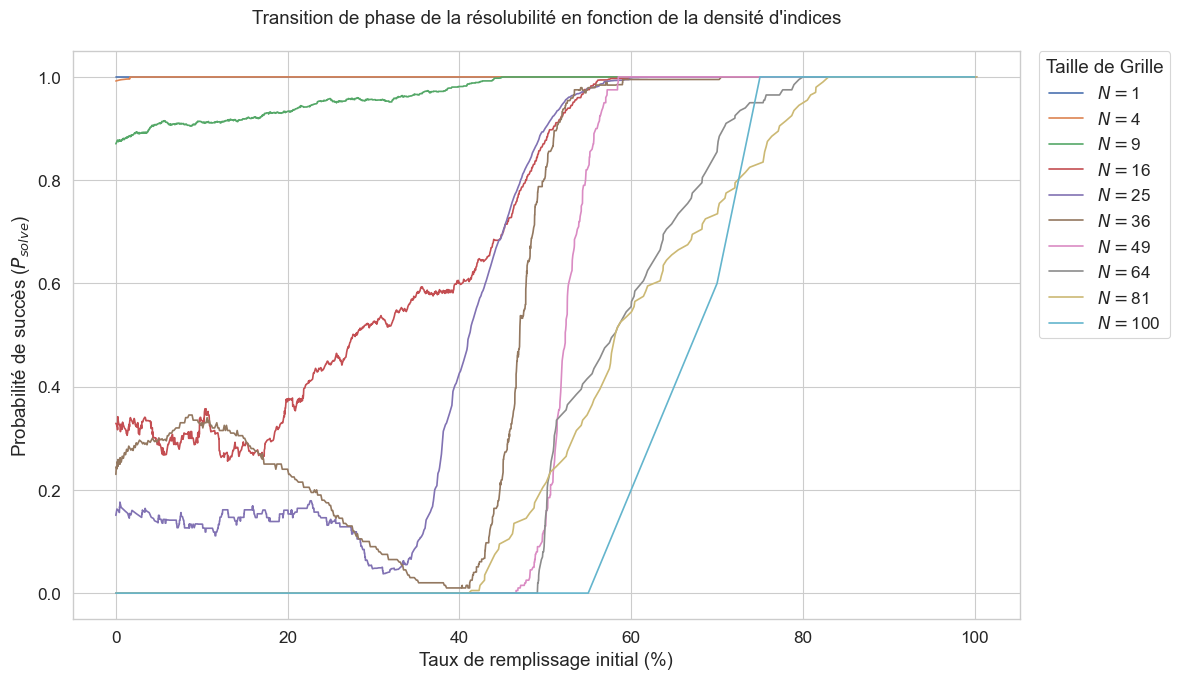

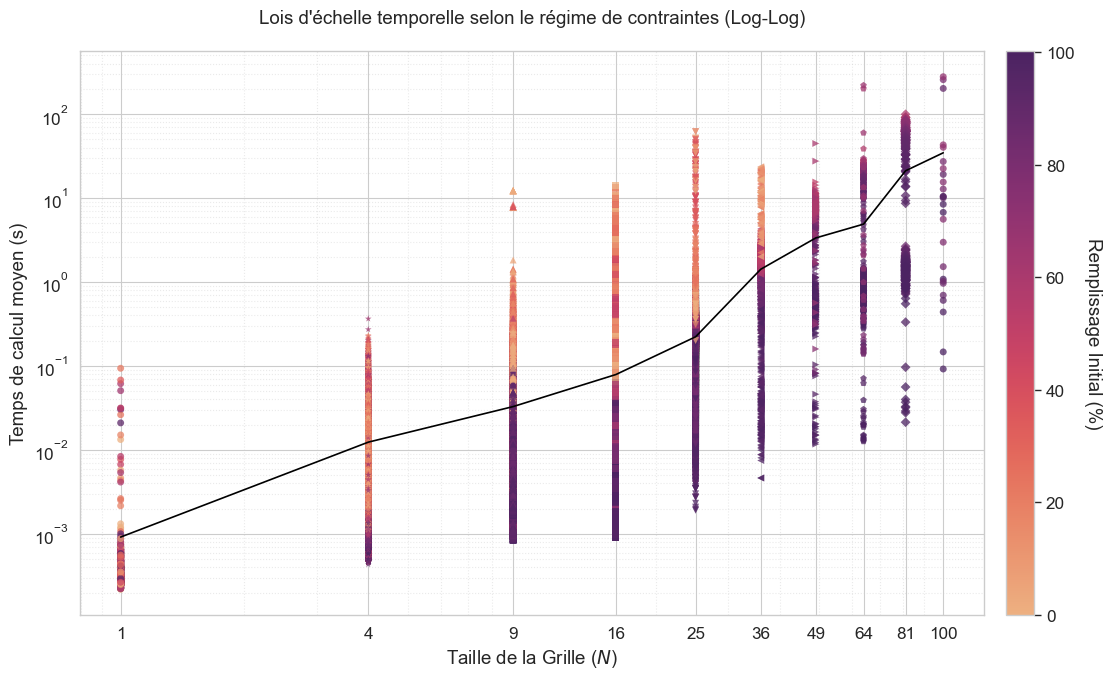

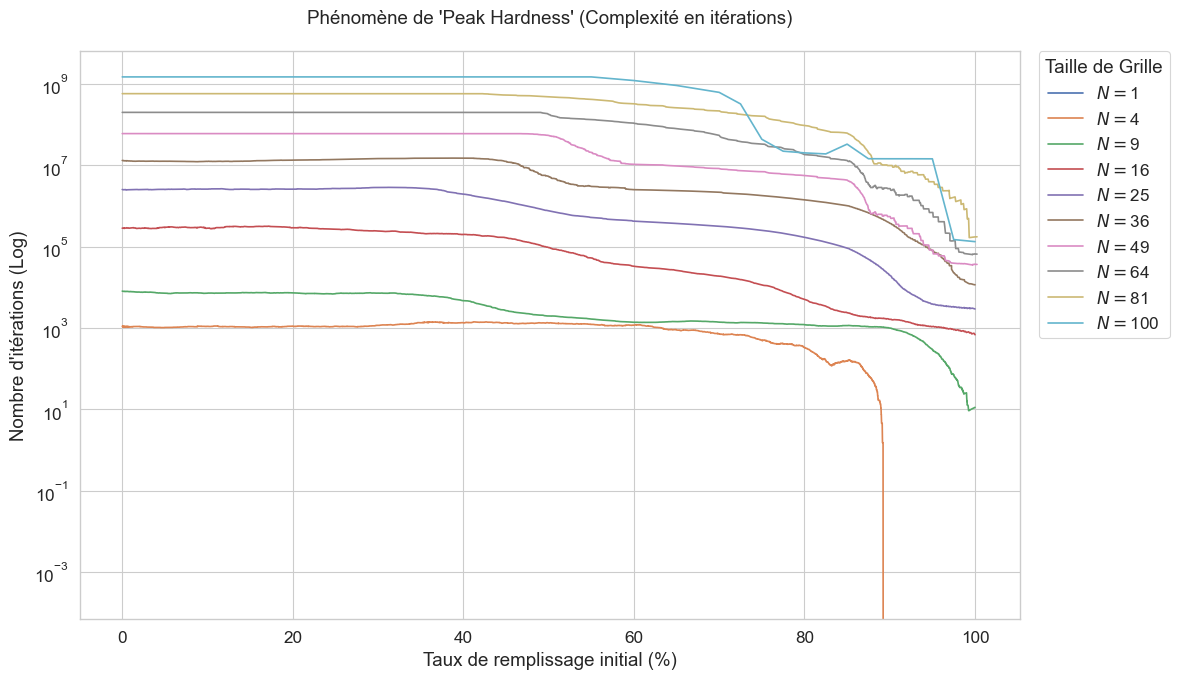

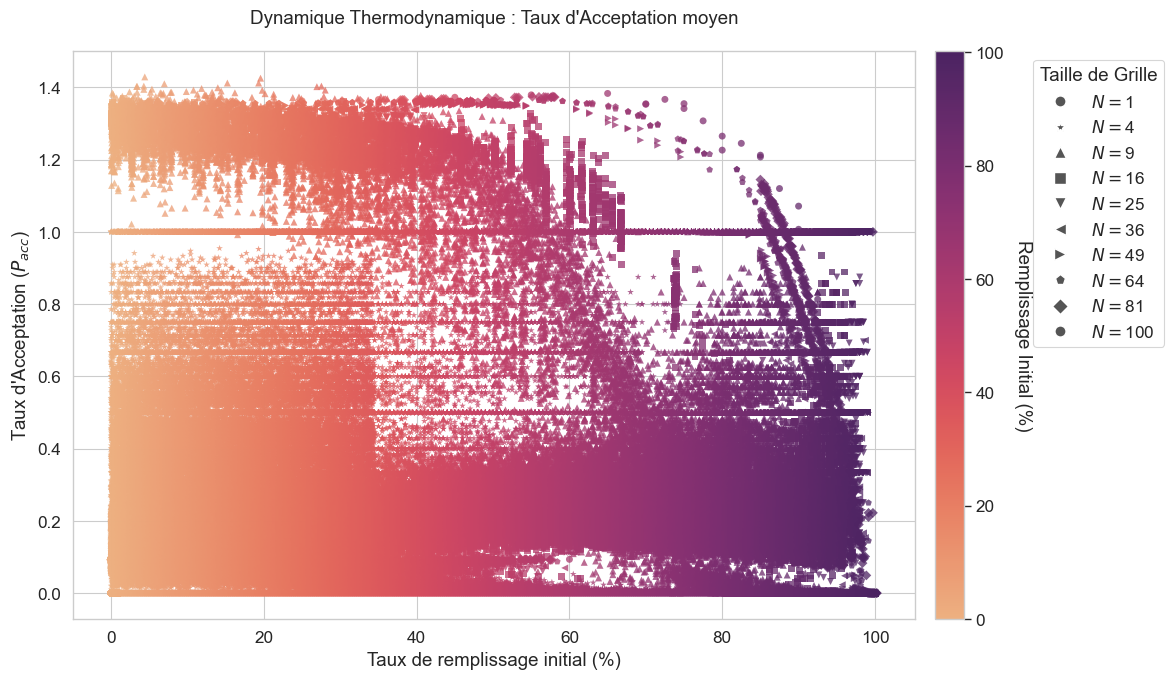

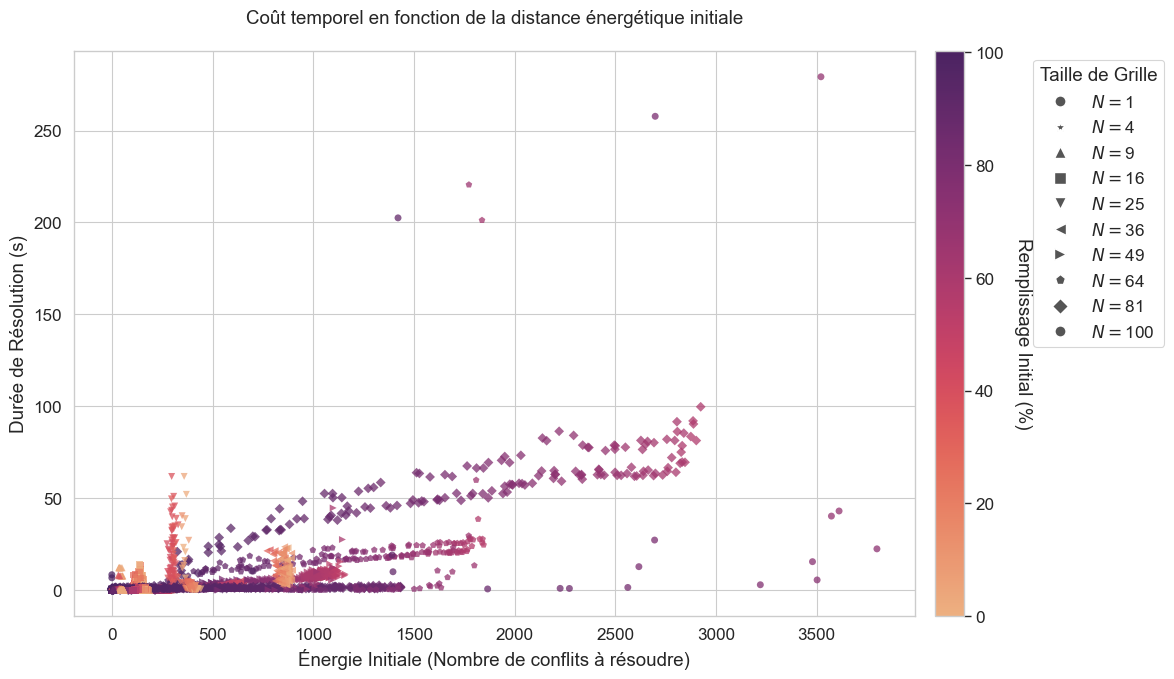

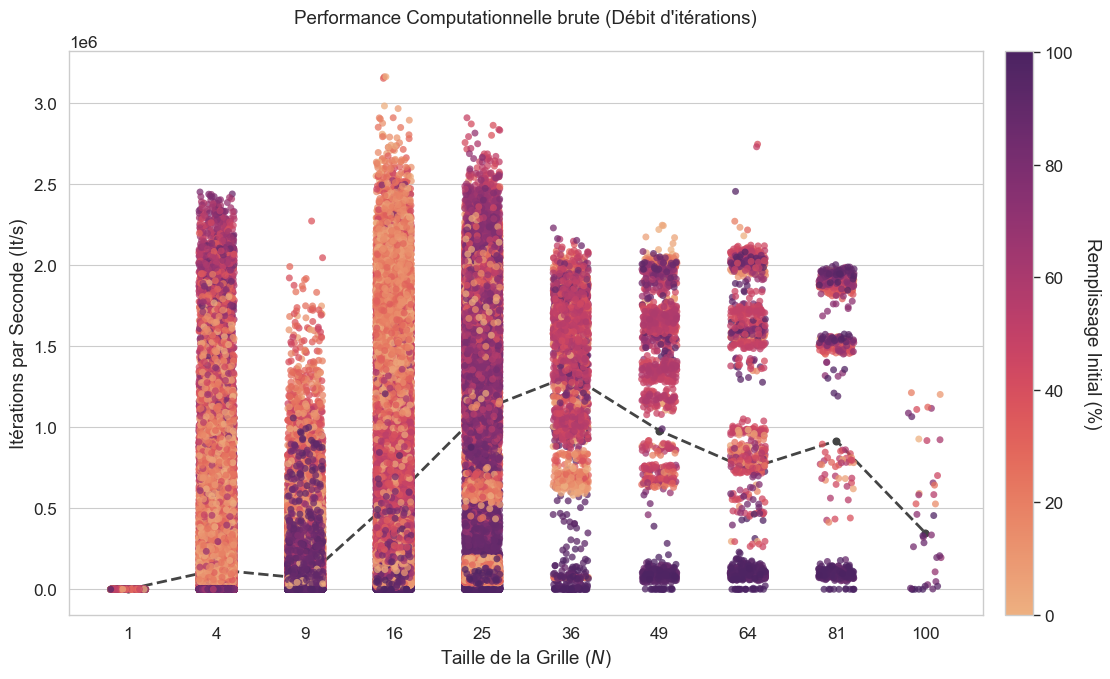

In [14]:
# Cellule 6 : Analyse Graphique
df = pd.read_csv("resultats_sudoku_complets.csv")

# Nettoyage
df = df[~((df['N_Size'] == 4) & (df['Duration'] > 6))]
df = df[~((df['N_Size'] == 1) & (df['Duration'] > 6))]
# df = df[~(df['N_Size'] == 10)]

sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)

MH_SIZE = 5
PLOT_CONFIG = {
    'fig_size': (12, 7),
    'palette': "flare",
    'cmap': "flare",
    'alpha': 0.75,
    'linewidth': 1.2,
    'edgecolor': 'none',
    'line_markersize': MH_SIZE,
    'scatter_s': MH_SIZE ** 2,
    'rotation': 270,
    'labelpad': 20,
    'pad': 20,
}

def put_legend_outside(ax, title="Légende", handles=None, labels=None):
    if handles and labels:
        ax.legend(handles=handles, labels=labels, title=title, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=True)
    else:
        ax.legend(title=title, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=True)

def safe_weighted_avg(x, val_col, weight_col):
    vals = x[val_col].values
    weights = x[weight_col].values
    if np.sum(weights) == 0:
        return np.mean(vals)
    return np.average(vals, weights=weights)

df['N_Label'] = df['N_Size'].apply(lambda x: f"$N=${x}")
n_sizes = sorted(df['N_Size'].unique())
hue_order = [f"$N=${n}" for n in n_sizes]
markers_list = ['o', '*', '^', 's', 'v', '<', '>', 'p', 'D']
markers_dict = {f"$N=${n}": markers_list[i % len(markers_list)] for i, n in enumerate(n_sizes)}

shape_handles = [Line2D([0], [0], marker=markers_dict[f"$N=${n}"], color='w', label=f"$N=${n}", markerfacecolor='#555555', markersize=8) for n in n_sizes]

plt.figure(figsize=PLOT_CONFIG['fig_size'])
df_agg_success = df.groupby(['Fixed_Pct', 'N_Label'], as_index=False)['Success'].mean()
smoothed_data = []
for n_lab in df_agg_success['N_Label'].unique():
    sub_df = df_agg_success[df_agg_success['N_Label'] == n_lab].sort_values('Fixed_Pct')
    raw_count = len(df[df['N_Label'] == n_lab])
    win_size = get_dynamic_window(raw_count)
    sub_df['Success'] = sub_df['Success'].rolling(window=win_size, min_periods=1, center=True).mean()
    smoothed_data.append(sub_df)
df_agg_success = pd.concat(smoothed_data)

ax = sns.lineplot(
    data=df_agg_success, 
    x='Fixed_Pct', 
    y='Success', 
    hue='N_Label', 
    hue_order=hue_order,
    style='N_Label',
    style_order=hue_order,
    markers=False,
    dashes=False,
    linewidth=PLOT_CONFIG['linewidth'],
    markersize=PLOT_CONFIG['line_markersize'],
    err_style=None,
    markeredgecolor='none'
)
plt.title("Transition de phase de la résolubilité en fonction de la densité d'indices", pad=PLOT_CONFIG['pad'])
plt.xlabel("Taux de remplissage initial (%)")
plt.ylabel("Probabilité de succès ($P_{solve}$)")
put_legend_outside(plt.gca(), "Taille de Grille")
plt.tight_layout()
plt.show()

plt.figure(figsize=PLOT_CONFIG['fig_size'])
df_success = df[df['Success'] == True].copy()

weighted_duration = df_success.groupby('N_Size')[['Duration', 'Fixed_Pct']].apply(
    lambda x: safe_weighted_avg(x, 'Duration', 'Fixed_Pct')
)

plt.plot(weighted_duration.index, weighted_duration.values, marker='', linestyle='-', 
         linewidth=PLOT_CONFIG['linewidth'], label="Moyenne Pondérée", color='black',
         markersize=PLOT_CONFIG['line_markersize'])

ax = sns.scatterplot(
    data=df_success, 
    x='N_Size', 
    y='Duration', 
    hue='Fixed_Pct', 
    style='N_Label',
    markers=markers_dict,
    palette=PLOT_CONFIG['palette'], 
    alpha=PLOT_CONFIG['alpha'], 
    s=PLOT_CONFIG['scatter_s'],
    edgecolor='none',
    linewidth=0,
    legend=False,
    rasterized=True
)
plt.yscale('log')
plt.xscale('log')
plt.title("Lois d'échelle temporelle selon le régime de contraintes (Log-Log)", pad=PLOT_CONFIG['pad'])
plt.xlabel("Taille de la Grille ($N$)")
plt.ylabel("Temps de calcul moyen (s)")
plt.xticks(n_sizes, labels=n_sizes)
plt.grid(True, which="minor", ls=":", alpha=0.4)
norm = plt.Normalize(df['Fixed_Pct'].min(), df['Fixed_Pct'].max())
sm = plt.cm.ScalarMappable(cmap=PLOT_CONFIG['cmap'], norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Remplissage Initial (%)", rotation=PLOT_CONFIG['rotation'], labelpad=PLOT_CONFIG['labelpad'])
# ax.legend(handles=shape_handles, title="Taille de Grille", bbox_to_anchor=(1.13, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=PLOT_CONFIG['fig_size'])
df_agg_iter = df.groupby(['Fixed_Pct', 'N_Label'], as_index=False)['Iterations'].mean()
smoothed_iter = []
for n_lab in df_agg_iter['N_Label'].unique():
    sub_df = df_agg_iter[df_agg_iter['N_Label'] == n_lab].sort_values('Fixed_Pct')
    raw_count = len(df[df['N_Label'] == n_lab])
    win_size = get_dynamic_window(raw_count)
    sub_df['Iterations'] = sub_df['Iterations'].rolling(window=win_size, min_periods=1, center=True).mean()
    smoothed_iter.append(sub_df)
df_agg_iter = pd.concat(smoothed_iter)

ax = sns.lineplot(
    data=df_agg_iter, 
    x='Fixed_Pct', 
    y='Iterations', 
    hue='N_Label',
    hue_order=hue_order,
    style='N_Label',
    style_order=hue_order,
    markers=False,
    dashes=False,
    linewidth=PLOT_CONFIG['linewidth'],
    markersize=PLOT_CONFIG['line_markersize'],
    markeredgecolor='none'
)
plt.yscale('log')
plt.title("Phénomène de 'Peak Hardness' (Complexité en itérations)", pad=PLOT_CONFIG['pad'])
plt.xlabel("Taux de remplissage initial (%)")
plt.ylabel("Nombre d'itérations (Log)")
put_legend_outside(plt.gca(), "Taille de Grille")
plt.tight_layout()
plt.show()

plt.figure(figsize=PLOT_CONFIG['fig_size'])
ax = sns.scatterplot(
    data=df,
    x='Fixed_Pct',
    y='Accept_Rate',
    hue='Fixed_Pct',
    style='N_Label',
    markers=markers_dict,
    palette=PLOT_CONFIG['palette'],
    s=PLOT_CONFIG['scatter_s'],
    alpha=PLOT_CONFIG['alpha'],
    edgecolor='none',
    linewidth=0,
    legend=False,
    rasterized=True
)
norm = plt.Normalize(df['Fixed_Pct'].min(), df['Fixed_Pct'].max())
sm = plt.cm.ScalarMappable(cmap=PLOT_CONFIG['cmap'], norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Remplissage Initial (%)", rotation=PLOT_CONFIG['rotation'], labelpad=PLOT_CONFIG['labelpad'])
ax.legend(handles=shape_handles, title="Taille de Grille", bbox_to_anchor=(1.13, 1), loc='upper left')
plt.title("Dynamique Thermodynamique : Taux d'Acceptation moyen", pad=PLOT_CONFIG['pad'])
plt.xlabel("Taux de remplissage initial (%)")
plt.ylabel("Taux d'Acceptation ($P_{acc}$)")
plt.tight_layout()
plt.show()

plt.figure(figsize=PLOT_CONFIG['fig_size'])
ax = sns.scatterplot(
    data=df[df['Success'] == True],
    x='Energy_Init',
    y='Duration',
    hue='Fixed_Pct',
    style='N_Label',
    markers=markers_dict,
    palette=PLOT_CONFIG['palette'],
    s=PLOT_CONFIG['scatter_s'],
    alpha=PLOT_CONFIG['alpha'],
    edgecolor='none',
    linewidth=0,
    legend=False,
    rasterized=True
)
norm = plt.Normalize(df['Fixed_Pct'].min(), df['Fixed_Pct'].max())
sm = plt.cm.ScalarMappable(cmap=PLOT_CONFIG['cmap'], norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Remplissage Initial (%)", rotation=PLOT_CONFIG['rotation'], labelpad=PLOT_CONFIG['labelpad'])
ax.legend(handles=shape_handles, title="Taille de Grille", bbox_to_anchor=(1.13, 1), loc='upper left')
plt.title("Coût temporel en fonction de la distance énergétique initiale", pad=PLOT_CONFIG['pad'])
plt.xlabel("Énergie Initiale (Nombre de conflits à résoudre)")
plt.ylabel("Durée de Résolution (s)")
plt.tight_layout()
plt.show()

plt.figure(figsize=PLOT_CONFIG['fig_size'])
ax = sns.stripplot(
    data=df,
    x='N_Size',
    y='Iter_Per_Sec',
    hue='Fixed_Pct',
    palette=PLOT_CONFIG['palette'],
    alpha=PLOT_CONFIG['alpha'],
    size=5,
    jitter=0.2,
    legend=False
)

weighted_ips = df.groupby('N_Size')[['Iter_Per_Sec', 'Fixed_Pct']].apply(
    lambda x: safe_weighted_avg(x, 'Iter_Per_Sec', 'Fixed_Pct')
)

plt.plot(range(len(n_sizes)), weighted_ips.values, color='#444', linewidth=2, linestyle='--', marker='o', label="Moyenne Pondérée")
plt.title("Performance Computationnelle brute (Débit d'itérations)", pad=PLOT_CONFIG['pad'])
plt.xlabel("Taille de la Grille ($N$)")
plt.ylabel("Itérations par Seconde (It/s)")
norm = plt.Normalize(df['Fixed_Pct'].min(), df['Fixed_Pct'].max())
sm = plt.cm.ScalarMappable(cmap=PLOT_CONFIG['cmap'], norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label("Remplissage Initial (%)", rotation=PLOT_CONFIG['rotation'], labelpad=PLOT_CONFIG['labelpad'])
plt.tight_layout()
plt.show()

---